In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from kepler import kepler

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
kicid = 4471379

data = np.loadtxt("kic{0}_lc.txt".format(kicid))
fulltimes = data[:, 0] # days
tmid = 0.5*(fulltimes[0] + fulltimes[-1])
times = fulltimes - tmid
dmmags = data[:, 1] * 1000. # mmags

# times = times[2500:]
# dmmags = dmmags[2500:]

metadata = np.loadtxt("kic{0}_metadata.csv".format(kicid), delimiter=",", skiprows=1)

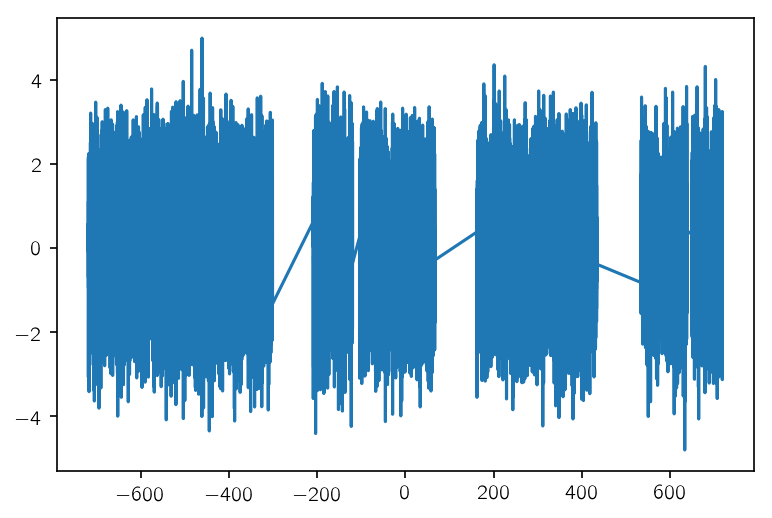

In [4]:
plt.plot(times,dmmags)

In [5]:
nu_arr = metadata[::6]
nu_arr

array([ 18.45056698,  16.99028309,  20.12632319,  13.96350005,
        12.41312666,  13.74493948,  18.82641509,  12.00985714,  21.95209572])

In [6]:
# orbits = pd.read_csv("orbits.csv").rename(columns = lambda x: x.strip())
# orbits.columns

In [7]:
# orb_params = orbits[orbits.Name == "kic{0}".format(kicid)].iloc[0]
# porb = orb_params.Porb
# a1 = orb_params["a1sini/c"]
# tp = orb_params["t_p"] - tmid
# e = orb_params["e"]
# varpi = orb_params["varpi"]
# a1d = a1/86400.0
# e_param = np.log(e) - np.log(1.0 - e)

Here's where the TensorFlow stuff starts. The "session" is the thing that will actually do that calculations.

In [8]:
sess = tf.InteractiveSession()

The way that TensorFlow works is that you define the operations on `Variable` and `placeholder` objects. Here we describe the model: 

In [9]:
T = tf.float64

# First the variables that we might want to optimize:
porb_tensor = tf.Variable(900.0, dtype=T)
tp_tensor = tf.Variable(0.0, dtype=T)
nu_tensor = tf.Variable(nu_arr, dtype=T)
e_param_tensor = tf.Variable(0.0, dtype=T)  # This forces the ecc to be between 0 and 1
e_tensor = 1.0 / (1.0 + tf.exp(-e_param_tensor))
varpi_tensor = tf.Variable(0.0, dtype=T)
log_sigma2_tensor = tf.Variable(0.0, dtype=T)  # Variance from observational uncertainties and model misspecification

ad_tensor = tf.Variable(0.01 + np.zeros_like(nu_arr), dtype=T)

# These are some placeholders for the data:
times_tensor = tf.placeholder(T, times.shape)
dmmags_tensor = tf.placeholder(T, dmmags.shape)

# Solve Kepler's equation
mean_anom = 2.0 * np.pi * (times_tensor - tp_tensor) / porb_tensor
ecc_anom = kepler(mean_anom, e_tensor)
true_anom = 2.0 * tf.atan2(tf.sqrt(1.0+e_tensor)*tf.tan(0.5*ecc_anom), tf.sqrt(1.0-e_tensor) + tf.zeros_like(times_tensor))

In [10]:
# Here we define how the time delay will be calculated:
tau_tensor = -(1.0 - tf.square(e_tensor)) * tf.sin(true_anom + varpi_tensor) / (1.0 + e_tensor*tf.cos(true_anom))

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

Here's how you could evaluate different parts of the model:

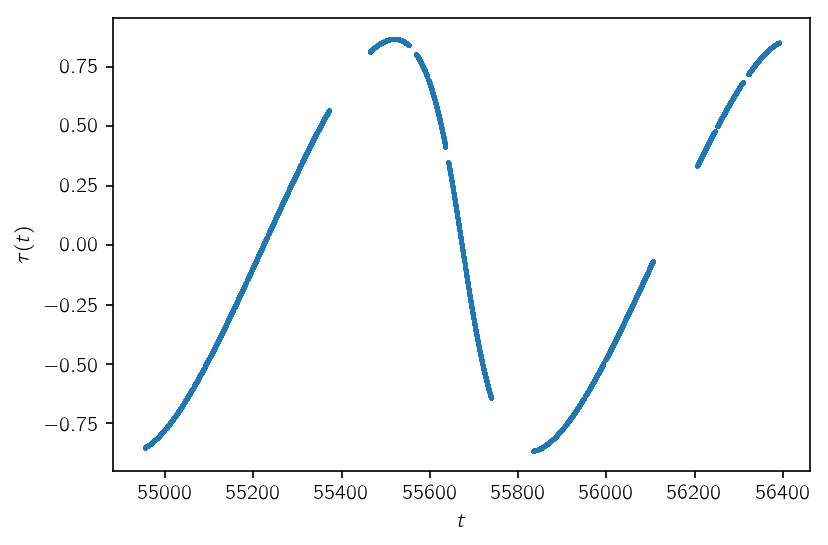

In [11]:
# We need to initialize the variables:
tf.global_variables_initializer().run()

# We'll also need to pass in the data:
data = {times_tensor: times, dmmags_tensor: dmmags}

# Let's plot the initial time delay
initial_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

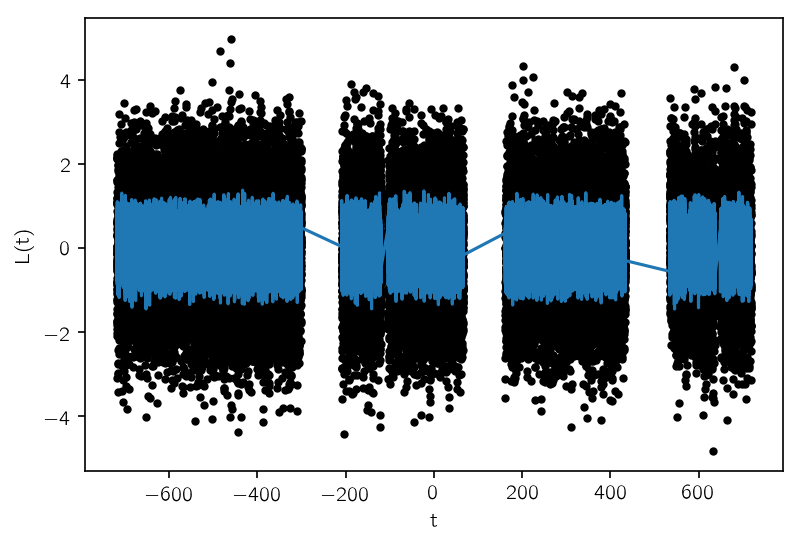

In [12]:
initial_model = sess.run(model_tensor, feed_dict=data)
plt.plot(times, dmmags, ".k")
plt.plot(times, initial_model)
# plt.xlim(100, 102)
# plt.ylim(-75, 75)
plt.xlabel("t")
plt.ylabel("L(t)");

Now we'll fit the parameters. We'll iterate with different subsets a few times.

In [13]:
old_chi2 = sess.run(chi2_tensor, feed_dict=data)
for i in range(2):
    params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(ad_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [e_param_tensor, varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
        
    new_chi2 = sess.run(chi2_tensor, feed_dict=data)
    print(old_chi2 - new_chi2)
    old_chi2 = new_chi2

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 45104.616676
  Number of iterations: 27
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42297.724558
  Number of iterations: 25
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42037.433411
  Number of iterations: 54
  Number of functions evaluations: 59
17752.063543
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42037.157225
  Number of iterations: 4
  Number of functions evaluations: 6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function valu

Let's make the updated final plots.

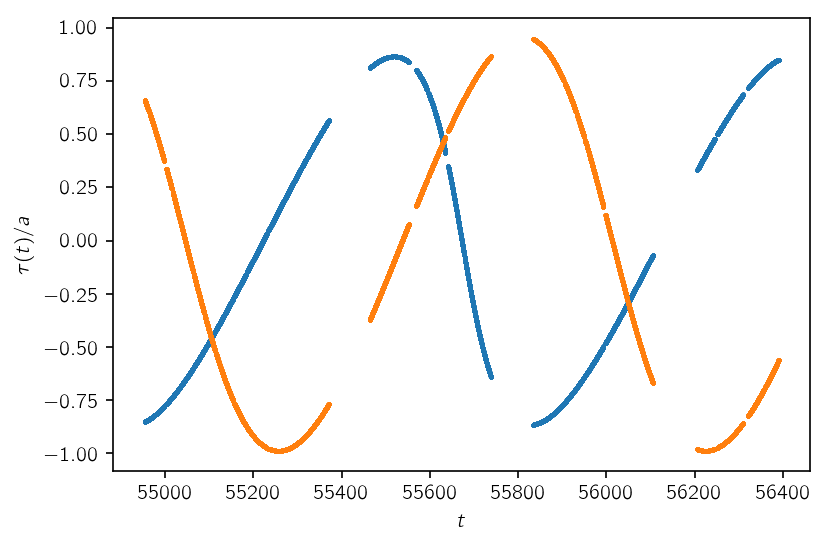

In [14]:
final_tau = sess.run(tau_tensor, feed_dict=data)
plt.plot(times+tmid, initial_tau, ".", ms=2)
plt.plot(times+tmid, final_tau, ".", ms=2)
plt.ylabel(r"$\tau(t) / a$")
plt.xlabel("$t$");

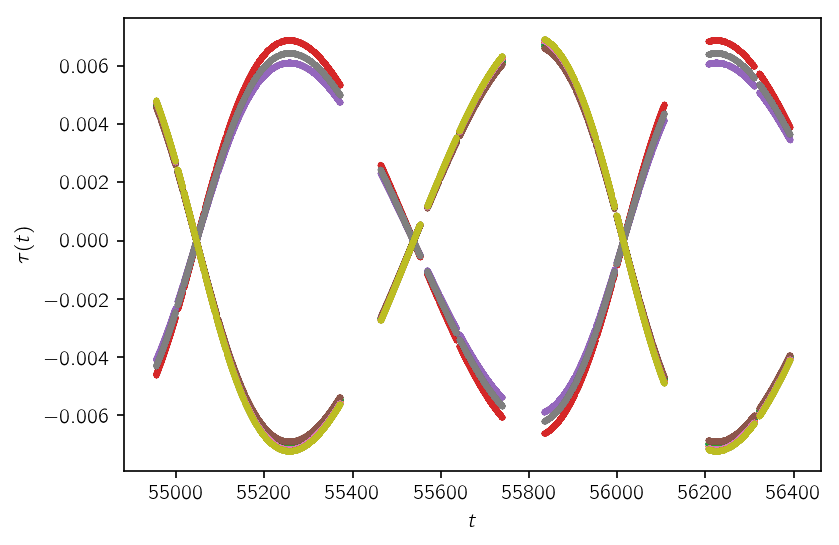

In [15]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times+tmid, sess.run(models, feed_dict=data), ".", ms=3)
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

In [16]:
ad = sess.run(ad_tensor)
if np.any(ad < 0):
    ad = [np.mean(ad[ad > 0]), np.mean(ad[ad < 0])]
else:
    ad = [np.mean(ad)]

In [17]:
inds = tf.cast(0.5 - 0.5 * (ad_tensor / tf.abs(ad_tensor)), tf.int32)
ad_params = tf.Variable(ad, dtype=T)
sess.run(ad_params.initializer)
ad_tensor = tf.gather(ad_params, inds)

# And the design matrix:
arg_tensor = 2.0 * np.pi * nu_tensor[None, :] * (times_tensor[:, None] - ad_tensor[None, :] * tau_tensor[:, None])
D_tensor = tf.concat([tf.cos(arg_tensor), tf.sin(arg_tensor)], axis=1)

# Define the linear solve for W_hat:
DTD_tensor = tf.matmul(D_tensor, D_tensor, transpose_a=True)
DTy_tensor = tf.matmul(D_tensor, dmmags_tensor[:, None], transpose_a=True)
W_hat_tensor = tf.linalg.solve(DTD_tensor, DTy_tensor)

# Finally, the model and the chi^2 objective:
model_tensor = tf.squeeze(tf.matmul(D_tensor, W_hat_tensor))
chi2_tensor = tf.reduce_sum(tf.square(dmmags_tensor - model_tensor)) * tf.exp(-log_sigma2_tensor)
chi2_tensor += len(times) * log_sigma2_tensor

In [18]:
for i in range(4):
    params = [log_sigma2_tensor, porb_tensor, tp_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(ad_params)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

    params += [e_param_tensor, varpi_tensor]
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)
    
    params.append(nu_tensor)
    opt = tf.contrib.opt.ScipyOptimizerInterface(chi2_tensor, params, method="L-BFGS-B")
    opt.minimize(sess, feed_dict=data)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42039.197375
  Number of iterations: 1
  Number of functions evaluations: 3
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42039.053335
  Number of iterations: 6
  Number of functions evaluations: 9
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42039.053335
  Number of iterations: 1
  Number of functions evaluations: 4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42036.956031
  Number of iterations: 11
  Number of functions evaluations: 17
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 42036.955954
 

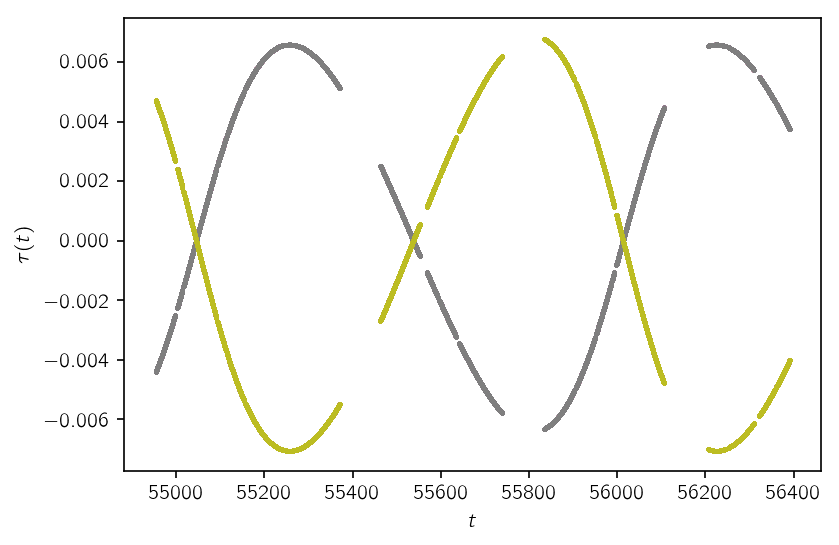

In [19]:
models = tau_tensor[:, None] * ad_tensor[None, :]
plt.plot(times+tmid, sess.run(models, feed_dict=data), ".", ms=2);
plt.ylabel(r"$\tau(t)$")
plt.xlabel("$t$");

In [26]:
hess_tensor = tf.hessians(-0.5*chi2_tensor, params[:-1])

In [27]:
hess = sess.run(hess_tensor, feed_dict=data)

In [31]:
1. / np.sqrt(-hess[1])

2.2875790308369059

In [38]:
def log_prob(theta, session, data, log_prob_fn, params):
    i = 0
    for p in params:
        l = p.shape
        if len(l):
            l = int(l[0])
            p.assign(params[i:i+l])
            i += l
        else:
            p.assign(params[i])
            i += 1
    return session.run(log_prob_fn, feed_dict=data)

In [64]:
log_prob_fn = -e_param_tensor - 2.0 * tf.log(1.0 + tf.exp(-e_param_tensor)) # -0.5 * chi2_tensor
# params = [log_sigma2_tensor, porb_tensor, tp_tensor, a1d_tensor, e_param_tensor, varpi_tensor, nu_tensor[0]]
params = [e_param_tensor]

theta = np.concatenate(list(map(np.atleast_1d, sess.run(params))))
log_prob(theta, sess, data, log_prob_fn, params)

-1.3885014086701075

In [65]:
import emcee

nwalkers = 32
ndim = len(initial)
p0 = initial + 1e-8*np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(sess, data, log_prob_fn, params))
sampler.run_mcmc(p0, 100, progress=True);

100%|██████████| 100/100 [03:44<00:00,  2.36s/it]


In [66]:
chain = sampler.get_chain();

/Users/dforeman/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


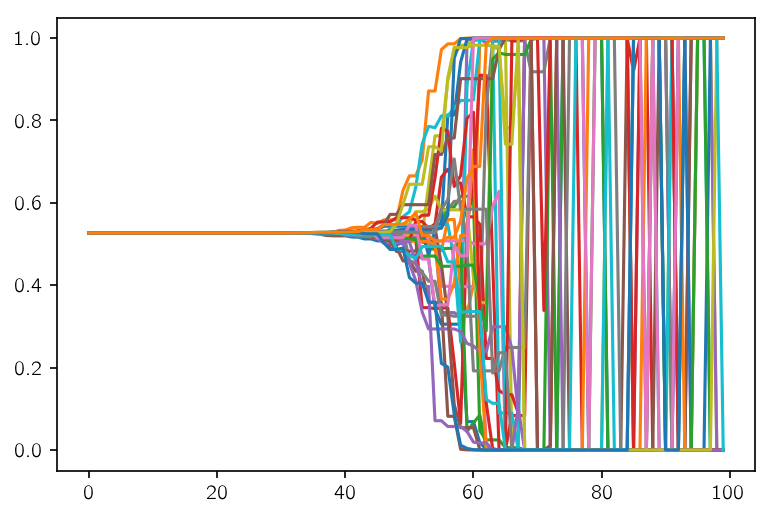

In [67]:
plt.plot(1.0 / (1 + np.exp(-chain[:, :, 0])));

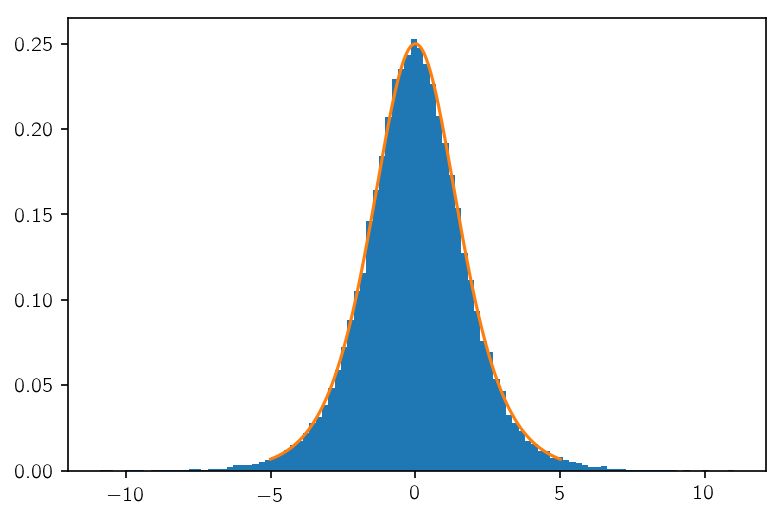

In [63]:
e0 = np.random.uniform(0, 1, 50000)
e0_param = np.log(e0) - np.log(1.0 - e0)
plt.hist(e0_param, 100, normed=True)
xx = np.linspace(-5, 5, 1000)
plt.plot(xx, np.exp(-xx)/(1+np.exp(-xx))**2);